In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

PyTorchには[torchvision](https://pytorch.org/docs/stable/torchvision/index.html)と呼ばれるライブラリが含まれており、機械学習の画像データセットとしてよく使われているImagenet, CIFAR10, MNISTなどが利用できます。
今回のチュートリアルではCIFAR10のデータセットを利用します。

画像の前処理を行う[TorchVision.transform](https://https://pytorch.org/docs/stable/torchvision/transforms.html)



画像の学種の前処理として、ndarryで`Height x Width x Channel`で表現される画像データを`Channel x Height x Width`のTensorデータに変換します。
```
transform = torchvision.transforms.ToTensor()
TensorData = transform(ndarray)
```
で変換できます。

入力画像の正規化を行う`torchvision.transforms.Normalize（mean、std、inplace = False ）`。`inplace`はオプション。チャンネル数だけのmean(平均) std(偏差)をそれぞれ与えることで各チャンネルごとに正規化を行う。

最後に、`torchvision.transforms.Compose（変換）`で、これらの前処理をまとめてインスタンスとして構成できます。

例
```
>>> transforms.Compose([
>>>     transforms.CenterCrop(10),
>>>     transforms.ToTensor(),
>>> ])
```

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # Normalize(平均, 偏差)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


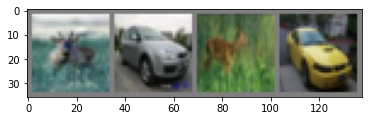

 deer   car  deer   car


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 訓練データをランダムに取得
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 画像の表示
imshow(torchvision.utils.make_grid(images))
# ラベルの表示
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# CNN
データの用意ができたので次に画像認識において有効なニューラルネットワークであるCNN(Convolutional Neural Network)のをpytorch内のライブラリを用いて定義します

今回定義したCNNは、
入力層 → 畳み込み層 → プーリング層 → 畳み込み層 → プーリング層 →
全結合層 → 全結合層 → 全結合層 → 出力層
という構成になっています。

forward関数内にあるview関数は１つ目の引数に-1を入れることで、２つ目の引数で指定した値にサイズ数を自動的に調整してくれます。

In [ ]:
# ニューラルネットワーク（NN）を構成する際に使用するライブラリ
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    # NNの各構成要素を定義
    def __init__(self):
        super(Net, self).__init__()

        # 畳み込み層とプーリング層の要素定義
        self.conv1 = nn.Conv2d(3, 6, 5)  # (入力, 出力, 畳み込みカーネル（5*5）)
        self.pool = nn.MaxPool2d(2, 2)  # (2*2)のプーリングカーネル
        self.conv2 = nn.Conv2d(6, 16, 5)
        # 全結合層の要素定義
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # (入力, 出力)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # クラス数が１０なので最終出力数は10

    # この順番でNNを構成
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # conv1->relu->pool
        x = self.pool(F.relu(self.conv2(x)))  # conv2->relu->pool
        x = x.view(-1, 16 * 5 * 5)  # データサイズの変更
        x = F.relu(self.fc1(x))  # fc1->relu
        x = F.relu(self.fc2(x))  # fc2->relu
        x = self.fc3(x)
        return x


net = Net().to(device) #GPUにインスタンスをキャスト

# 損失関数とオプティマイザの定義
損失関数とオプティマイザは以下の関数で簡単に定義できます。
今回は損失関数に交差エントロピーを、オプティマイザにAdamを使用します。学習率は0.001です。

In [ ]:
import torch.optim as optim  #オプティマイザ用のライブラリ

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
for epoch in range(50): 

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

        # 訓練データから入力画像の行列とラベルを取り出す
        inputs, labels = data

        inputs, labels = inputs.to(device), labels.to(device) #GPUにデータをキャスト

        # 勾配パラメータを０にする
        optimizer.zero_grad()

        # 順伝播 → 逆伝播 → 勾配パラメータの最適化
        outputs = net(inputs) #モデルに入れて出力を得る
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 損失関数の変化を2000ミニバッチごとに表示
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.868
[1,  4000] loss: 1.580
[1,  6000] loss: 1.507
[1,  8000] loss: 1.477
[1, 10000] loss: 1.421
[1, 12000] loss: 1.378
[2,  2000] loss: 1.298
[2,  4000] loss: 1.309
[2,  6000] loss: 1.299
[2,  8000] loss: 1.277
[2, 10000] loss: 1.264
[2, 12000] loss: 1.261
[3,  2000] loss: 1.188
[3,  4000] loss: 1.168
[3,  6000] loss: 1.188
[3,  8000] loss: 1.194
[3, 10000] loss: 1.158
[3, 12000] loss: 1.188
[4,  2000] loss: 1.107
[4,  4000] loss: 1.107
[4,  6000] loss: 1.110
[4,  8000] loss: 1.107
[4, 10000] loss: 1.109
[4, 12000] loss: 1.134
[5,  2000] loss: 1.047
[5,  4000] loss: 1.077
[5,  6000] loss: 1.061
[5,  8000] loss: 1.074
[5, 10000] loss: 1.080
[5, 12000] loss: 1.068
[6,  2000] loss: 0.998
[6,  4000] loss: 1.010
[6,  6000] loss: 1.021
[6,  8000] loss: 1.035
[6, 10000] loss: 1.039
[6, 12000] loss: 1.053
[7,  2000] loss: 0.961
[7,  4000] loss: 0.986
[7,  6000] loss: 0.982
[7,  8000] loss: 1.014
[7, 10000] loss: 1.015
[7, 12000] loss: 1.020
[8,  2000] loss: 0.950
[8,  4000] 

# テストデータによるネットワークのテスト
ランダムに取り出したテストデータの画像とラベルを試しに表示させてみます。

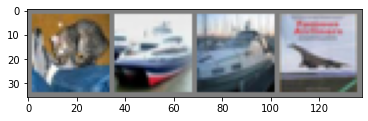

GroundTruth:    cat  ship  ship plane


In [ ]:
# 訓練データをランダムに取得
dataiter = iter(testloader)
images, labels = dataiter.next()

# 画像の表示
imshow(torchvision.utils.make_grid(images))
# ラベルの表示
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
# 予測
images = images.to(device) #GPUにデータをキャスト
outputs = net(images) # 訓練後のNNに画像を入力
_, predicted = torch.max(outputs, 1) #入力した画像の行列の最大値（もっとも確率の高いもの）を返す

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship plane plane


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 60 %


ラベルごとの予測

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 61 %
Accuracy of   car : 70 %
Accuracy of  bird : 52 %
Accuracy of   cat : 27 %
Accuracy of  deer : 51 %
Accuracy of   dog : 55 %
Accuracy of  frog : 70 %
Accuracy of horse : 70 %
Accuracy of  ship : 70 %
Accuracy of truck : 74 %


```
Accuracy of plane : 53 %
Accuracy of   car : 62 %
Accuracy of  bird : 41 %
Accuracy of   cat : 45 %
Accuracy of  deer : 46 %
Accuracy of   dog : 50 %
Accuracy of  frog : 66 %
Accuracy of horse : 69 %
Accuracy of  ship : 78 %
Accuracy of truck : 76 %
```